<a href="https://colab.research.google.com/github/mijanr/GANs/blob/master/cGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [18]:
#load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [19]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [20]:
class_num = 10

In [21]:
#visualize the dataset
def imshow(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    img = torchvision.utils.make_grid(images)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


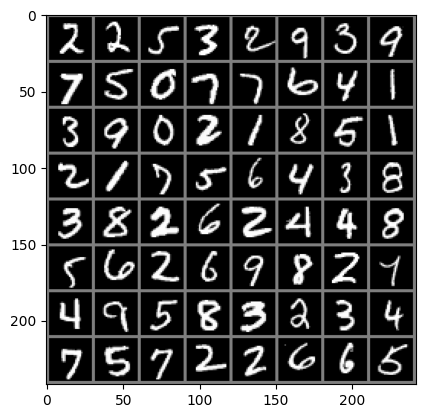

In [22]:
imshow(trainloader)

In [23]:
for images, labels in trainloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [24]:
#Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.embed = nn.Embedding(class_num, class_num)
        #output size = batch_size x 1x 28 x 28
        self.sequential = nn.Sequential(
            nn.Linear(100 + class_num, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            #flatten
            nn.Flatten(),
            nn.LazyLinear(out_features=28*28, bias=True),
            nn.Tanh()
        )
    def forward(self, x, label):
        label = self.embed(label)
        x = torch.cat([x, label], 1)
        x = self.sequential(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [26]:
generator = Generator().to(device)

/home/pops/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [27]:
#feed a random noise and a label to the generator
noise = torch.randn(64, 100, device=device)
labels = torch.randint(0, 10, (64,), device=device)
fake_images = generator(noise, labels)
print(fake_images.shape)

torch.Size([64, 1, 28, 28])


In [28]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.embed = nn.Embedding(class_num, class_num)
        self.sequential = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x, label):
        x = x.view(-1, 784)
        label = self.embed(label)
        x = torch.cat((x, label), dim=1)
        x = self.sequential(x)
        return x

In [29]:
discriminator = Discriminator().to(device)

In [30]:
#feed the fake image to the discriminator
output = discriminator(fake_images, labels)
print(output.shape)

torch.Size([64, 1])


In [31]:
#training
criterion = nn.BCELoss()
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

In [32]:
#training loop
num_epochs = 50
for epoch in range(num_epochs):
    for images, labels in trainloader:
        #train discriminator
        discriminator.zero_grad()
        real_images = images.to(device)
        real_labels = labels.to(device)
        real_output = discriminator(real_images, real_labels)
        real_loss = criterion(real_output, torch.ones_like(real_output))
        real_loss.backward()

        noise = torch.randn(batch_size, 100).to(device)
        fake_labels = torch.randint(0, 10, (batch_size,), device=device)
        fake_images = generator(noise, fake_labels)
        fake_output = discriminator(fake_images, fake_labels)
        fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
        fake_loss.backward()

        optimizerD.step()

        #train generator
        generator.zero_grad()
        noise = torch.randn(batch_size, 100).to(device)
        fake_labels = torch.randint(0, 10, (batch_size,), device=device)
        fake_images = generator(noise, fake_labels)
        fake_output = discriminator(fake_images, fake_labels)
        g_loss = criterion(fake_output, torch.ones_like(fake_output))
        g_loss.backward()
        optimizerG.step()
        #print loss
        if (epoch + 1) % 10 == 0:
            print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch + 1, num_epochs, real_loss.item() + fake_loss.item(), g_loss.item()))

Epoch [10/50], d_loss: 1.0914, g_loss: 1.3044
Epoch [10/50], d_loss: 1.0490, g_loss: 1.0109
Epoch [10/50], d_loss: 0.9955, g_loss: 1.3970
Epoch [10/50], d_loss: 1.1904, g_loss: 1.0716
Epoch [10/50], d_loss: 1.1302, g_loss: 0.9554
Epoch [10/50], d_loss: 1.1613, g_loss: 1.3307
Epoch [10/50], d_loss: 1.1770, g_loss: 1.1279
Epoch [10/50], d_loss: 1.1062, g_loss: 0.9837
Epoch [10/50], d_loss: 1.0186, g_loss: 1.4293
Epoch [10/50], d_loss: 1.1016, g_loss: 1.0941
Epoch [10/50], d_loss: 0.9861, g_loss: 1.0014
Epoch [10/50], d_loss: 0.9946, g_loss: 1.0642
Epoch [10/50], d_loss: 0.9298, g_loss: 1.2681
Epoch [10/50], d_loss: 1.0518, g_loss: 1.1415
Epoch [10/50], d_loss: 1.0276, g_loss: 1.2657
Epoch [10/50], d_loss: 1.0372, g_loss: 0.9771
Epoch [10/50], d_loss: 1.0833, g_loss: 1.1319
Epoch [10/50], d_loss: 1.1193, g_loss: 1.3330
Epoch [10/50], d_loss: 0.9356, g_loss: 1.1123
Epoch [10/50], d_loss: 1.0858, g_loss: 1.2997
Epoch [10/50], d_loss: 1.1066, g_loss: 0.9954
Epoch [10/50], d_loss: 1.0320, g_l

In [39]:
#gernerate image
noise = torch.randn(64, 100, device=device)
label = torch.randint(0, 1, (64,), device=device)
fake_image = generator(noise, label)
fake_image = fake_image.view(fake_image.size(0), 28, 28)
fake_image = fake_image.cpu().detach().numpy()

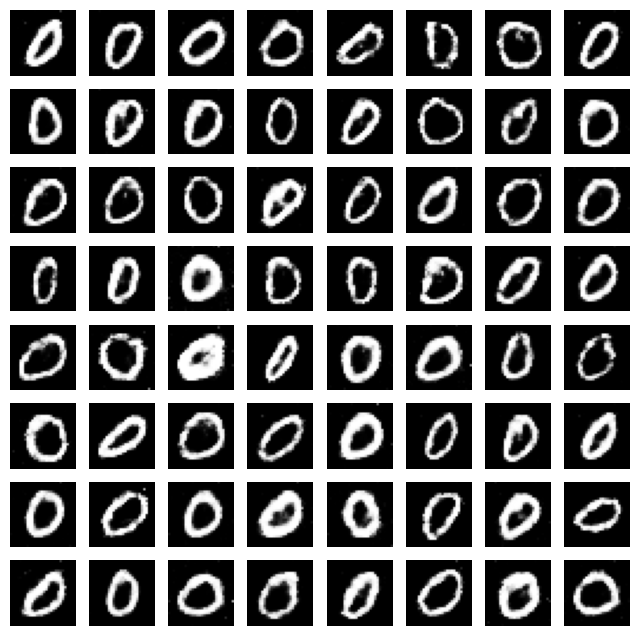

In [40]:
#visualize the generated image
plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(fake_image[i], cmap='gray')
    plt.axis('off')
plt.show()

In [41]:
# #save the model
# torch.save(generator.state_dict(), 'generator_mnist.pth')
# torch.save(discriminator.state_dict(), 'discriminator_mnist.pth')
